*Sign Language - Machine Learning*

---

Seminarski rad u sklopu kursa Mašinsko učenje - Matematički fakultet, Univerzitet u Beogradu

**Autori**  
Nikola Dimić i Zorana Gajić

**Opis projekta**  
 Cilj ovog projekta jeste da se konstruiše model za klasifikaciju slika znakovnog jezika kako bismo olakšali njegovo učenje i razumevanje.

**Baza podataka**  
Baza podataka sadrži 3000 slika za svako slovo. Znakovi su slikani iz različitih uglova i pod različitim osvetljenjem, kako bi se dobio što precizniji model. Link do baze je [ovde](https://www.kaggle.com/paultimothymooney/interpret-sign-language-with-deep-learning/data).

**Literatura**

* [Interpret Sign Language with Deep Learning - 2018](https://www.kaggle.com/paultimothymooney/interpret-sign-language-with-deep-learning/)

* [Sign Language Interpreter using Deep Learning](https://github.com/harshbg/Sign-Language-Interpreter-using-Deep-Learning#demo)

* [Hands-on Guide To Implementing AlexNet With Keras For Multi-Class Image Classification](https://analyticsindiamag.com/hands-on-guide-to-implementing-alexnet-with-keras-for-multi-class-image-classification/)

* [Step by step VGG16 implementation in Keras for beginners](https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c)

* [American Sign Language Hand Gesture Recognition](https://towardsdatascience.com/american-sign-language-hand-gesture-recognition-f1c4468fb177)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!unzip drive/My\ Drive/input.zip -d data

**Neophodne biblioteke**

In [3]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import random
import string

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras import utils


from sklearn.metrics import classification_report, confusion_matrix

**Pretprocesiranje slika**

Slike znakovnog jezika nalaze se u datotekama razvrstane po slovima. Prilikom učitavanja svake od datoteka, slika je obrađena u skladu sa potrebama mreže koja se trenira. Tako je svaka slika smanjena ili povećana u skladu sa odgovarajućim dimenzijama. Svakoj slici dodeljena je klasa u skladu sa datotekom u kojoj se nalaze, s tim što su klase konvertovane iz slovnog u brojevni zapis pa tako su slova *A,B...Z* redom označena rednim brojevima slova u abecedi (*0,1..25*), dok su specijalni karakteri *del*, *nothing* i *space* označeni brojevima *26,27,28* respektivno. Nakon obrade slika i pridruživanja klasa, ispisane su specifikacije skupa podataka, kao i dimenzije matrica kojima su opisane slike. 

In [4]:
def letterToNumber(letter):
    if(len(letter) == 1):
        letterNum = ord(letter.lower()) - 97
    elif(letter == 'del'):
        letterNum = 26
    elif(letter == 'nothing'):
        letterNum = 27
    elif(letter == 'space'):
        letterNum = 28
    else:
        letterNum = 29
    return letterNum

def proccessImage(imageFile, size=(200,200), color = True):
    color = 3 if color else 1
    resizedImage = resize(imageFile, (size[0], size[1], color), anti_aliasing=True)
    return np.asarray(resizedImage)

def resizeData(X, size=(200,200), color = True):
    Xnew = map(lambda img: proccessImage(img,size,color), X)
    return list(Xnew)

def logData(imageColor, imageSize, imagesPerLetter, item):
    print("Extracted data with the following specifications:")
    print("--------------------------------------------------")
    print("color: " + str(imageColor))
    print("size: " + str(imageSize))
    print("images per letter: " + str(imagesPerLetter))
    print("output shape: " + str(item.shape))

def exctractDataFromFiles(file, imageColor = True, imageSize = (200,200), imagesPerLetter='all'):
    color = 1 if imageColor else 0
    X = []
    y = []
    for folderName in os.listdir(file):
        if not folderName.startswith('.'):
            classLetter = folderName
            classNum = letterToNumber(classLetter)
            fullFolderName = file+folderName
            listOfImages = os.listdir(fullFolderName)
            random.shuffle(listOfImages)
            numOfImages = len(listOfImages) if imagesPerLetter == 'all' else imagesPerLetter
            
            for imageName in tqdm(listOfImages[0:numOfImages]):
                fullImageName = fullFolderName + "/" + imageName
                imageFile = cv2.imread(fullImageName, color)
                resizedImage = proccessImage(imageFile, imageSize, color)   
                X.append(resizedImage)
                y.append(classNum)
    X = np.asarray(X)
    y = np.asarray(y)
    logData(imageColor, imageSize, imagesPerLetter, X[0])
    return X,y


Zbog memorijskih i vremenskih ograničenja za svako slovo je uzeto po *1000* slika slučajnim izborom. Dakle, za treniranje mreže je iskorišćeno *30000* slika. Empirijskim metodama zaključeno je da je optimalna dimenzija slika *50x50*px.

In [5]:
trainFolder = "./data/input/asl-alphabet/asl_alphabet_train/"
#testFolder =  "../input/asl-alphabet/asl_alphabet_test/"

X, y = exctractDataFromFiles(trainFolder, imageColor = True, imageSize = (50, 50), imagesPerLetter = 1000)
X_gray, y_gray = exctractDataFromFiles(trainFolder, imageColor = False, imageSize = (50, 50), imagesPerLetter = 1000)

  3%|▎         | 30/1000 [00:00<00:03, 296.24it/s]

Extracted data with the following specifications:
--------------------------------------------------
color: True
size: (50, 50)
images per letter: 1000
output shape: (50, 50, 3)


100%|██████████| 1000/1000 [00:03<00:00, 320.67it/s]


Extracted data with the following specifications:
--------------------------------------------------
color: False
size: (50, 50)
images per letter: 1000
output shape: (50, 50, 1)


**Prikaz slike**


In [ ]:
def showLetter(letter):
  testImage = cv2.imread("./data/input/asl-alphabet/asl_alphabet_train/" + letter + "/" + letter + "1.jpg")
  resizedTestImage = proccessImage(testImage, size=(50,50), color=True)
  print(resizedTestImage.shape)
  plt.title("Letter " + letter)
  plt.imshow(resizedTestImage, cmap='gray')
  plt.show()

(50, 50, 3)


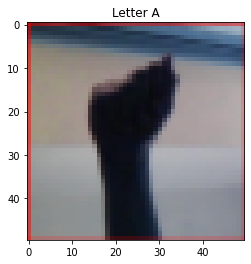

In [ ]:
showLetter('A')

(50, 50, 3)


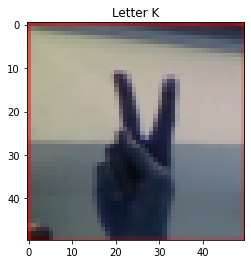

In [ ]:
showLetter('K')

**Pretprocesiranje ciljne promenljive**  
U sklopu transformacije ciljne promenljive je korišćeno `One-Hot encoding`, odnosno kodiranje koje kategoričkom atributu (ciljnoj promenljivoj) sa $k$ mogućih različitih vrednosti (gde je $k$ u našem slučaju vrednost 30) pridružuje $k$ novih promenljivih, a vrednostima kategoričke promenljive vrednosti indikatora.

0 &#8594; 1 0 0 0 ... 0  
1 &#8594; 0 1 0 0 ... 0  
2 &#8594; 0 0 1 0 ... 0  
...  
29 &#8594; 0 0 0 0 ... 0  

In [6]:
numOfClasses = 30

In [9]:
# One hot encoding of target variable
y = to_categorical(y, numOfClasses)
y_gray = to_categorical(y_gray, numOfClasses)

**Podela podataka na trening i test skup**  
Učitani podaci se dele na trening i test skup u odnosu *3:1*, s tim što se uz pomoć naglašenog parametra *stratify* čuva udeo ciljne promenljive iz originalnog skupa podataka.

In [10]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(X_gray, y_gray, test_size=0.33, stratify=y_gray)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19430, 50, 50, 3)
(9570, 50, 50, 3)
(19430, 30)
(9570, 30)


In [12]:
print(X_train_gray.shape)
print(X_test_gray.shape)
print(y_train_gray.shape)
print(y_test_gray.shape)

(19430, 50, 50, 1)
(9570, 50, 50, 1)
(19430, 30)
(9570, 30)


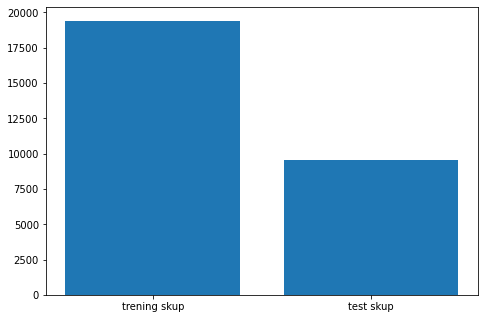

In [18]:
import matplotlib.pyplot as plt
train_size = X_train.shape[0]
test_size = X_test.shape[0]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
names = ["trening skup", "test skup"]
sizes = [train_size, test_size]
ax.bar(names,sizes)
plt.show()

**Početni model**  
Prvi pokušaj rešavanja problema je bila konvolutivna neuronska mreža sa arhitekturom sličnoj onoj prikazanoj na vežbama. Mreža je napravljena za slike dimenzije *50x50* koristeći 3 kanala za boju, pa je ulazna dimenzija *(50,50,3)* za svaku sliku. Korišćena je neuronska mreža sa propagacijom unapred, gde se dodaju sledeći slojevi:  
**1 sloj:** Konvolucioni sloj sa *16* filtera, kernelom veličine *3x3*, uokvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.    
**2 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti i veličinom bloka *2x2*.  
**3 sloj:** Konvolucioni sloj sa *32* filtera, kernelom veličine *3x3*, uokvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.    
**4 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti i veličinom bloka *2x2*.  
**5 sloj:** Konvolucioni sloj sa *64* filtera, kernelom veličine *3x3*, uokvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.  
Zatim funkcija koja se koristi za transformisanje matrica u vektore *Flatten*.    
**6 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *1024* i ReLu aktivacionom funkcijom.  
Zatim tehnika regularizacije kojom isključujemo nasumično odabrane neurone i omogućavamo drugačiji protok podataka kroz mrežu *Dropout*.  
**7 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *30* i *softmax* aktivacionom funkcijom. 

In [ ]:
# Creating model 
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(numOfClasses, activation='softmax'))

In [ ]:
# Model summary per layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 50, 50, 16)        448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)             

**Mrežu ćemo trenirati prema sledećim smernicama:**  
*Funkcija greške*: Kategorička unakrsna entropija  
*Optimizator*: Adam sa korakom učenja **0.001**   
*Broj epoha*: **12**  
*Veličina paketića za treniranje* (engl. batch size): **128**  

Za evaluaciju mreže koristimo **preciznost**.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_split=0.2, 
                    shuffle=True)

Epoch 1/100
122/122 [==============================] - 2s 20ms/step - loss: 2.7064 - accuracy: 0.2188 - val_loss: 1.6960 - val_accuracy: 0.4789
Epoch 2/100
122/122 [==============================] - 2s 17ms/step - loss: 1.3546 - accuracy: 0.5749 - val_loss: 0.8311 - val_accuracy: 0.7578
Epoch 3/100
122/122 [==============================] - 2s 17ms/step - loss: 0.7572 - accuracy: 0.7594 - val_loss: 0.5219 - val_accuracy: 0.8381
Epoch 4/100
122/122 [==============================] - 2s 17ms/step - loss: 0.4734 - accuracy: 0.8437 - val_loss: 0.2954 - val_accuracy: 0.9213
Epoch 5/100
122/122 [==============================] - 2s 17ms/step - loss: 0.3299 - accuracy: 0.8935 - val_loss: 0.2049 - val_accuracy: 0.9413
Epoch 6/100
122/122 [==============================] - 2s 17ms/step - loss: 0.2455 - accuracy: 0.9205 - val_loss: 0.1789 - val_accuracy: 0.9460
Epoch 7/100
122/122 [==============================] - 2s 17ms/step - loss: 0.1899 - accuracy: 0.9374 - val_loss: 0.1507 - val_accuracy:

**Brzina treniranja modela**

Kako za treniranje u svakoj od epoha u proseku bilo potrebno po 2.20s za treniranje celog skupa bilo je potrebno približno 3.7 minuta 


In [ ]:
# Plotting loss/accuracy values of train and validation data during training model
def plot_loss_accuracy(epochs, history):
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
  plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
  plt.legend(loc='best')

  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
  plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
  plt.legend(loc='best')

Na sledećem zajedničkom grafiku je prikazana funkcija gubitka na skupu za treniranje i validaciju, a potom i funkcija preciznosti. Na *X* osi se nalazi trenutna epoha dok se na *Y* osi nalazi gubitak, odnosno preciznost za datu epohu.  
Prema prikazanom grafiku, funkcija gubitka kao i funkcija preciznosti dostiže svoj minimum, odnosno maksimum već oko 50. epohe. Zato smo mogli ograničiti broj epoha na 60. Takođe se iz grafika može primetiti da u prvih 10 epoha funkcija gubitka odnosno preciznosti eksponencijalno opada odnosno raste, kako za validacioni tako i za trening skup. 

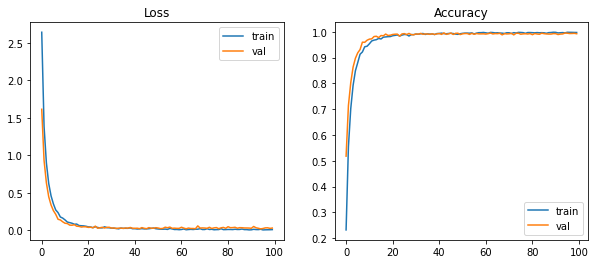

In [ ]:
plot_loss_accuracy(100, history)

Dalje je izvršena evaluacija modela na test i trening skupu i dobijena je preciznost od 99% u oba slučaja. Ono što bi trebalo da nas zanima jeste da li je ta preciznost ravnomerno raspoređena po klasama.

In [ ]:
# Evaluate model
score_test = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

Test loss: 0.027293771505355835
Test accuracy: 0.9924764633178711


In [ ]:
# Evaluate model
score_train = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])

Train loss: 0.006943640299141407
Train accuracy: 0.9982501268386841


In [ ]:
def show_classification_report(model, X_test, y_test):
  print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=-1)))

U sledećoj tabeli je predstavljen klasifikacioni izveštaj u kojem možemo videti da je preciznost ravnomerno raspoređena po klasama i da nema klase koja je znatno lošija u odnosu na neku drugu, vidimo da je preciznost > 98% za svaku klasu, što znači da je ovo jedan odličan model koji ima preciznost čak 99%.

In [ ]:
show_classification_report(model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       330
           1       1.00      0.99      1.00       330
           2       0.99      1.00      1.00       330
           3       1.00      0.99      1.00       330
           4       0.99      0.98      0.99       330
           5       1.00      1.00      1.00       330
           6       0.98      0.98      0.98       330
           7       0.98      0.99      0.99       330
           8       0.99      0.98      0.99       330
           9       0.99      0.98      0.99       330
          10       1.00      1.00      1.00       330
          11       1.00      1.00      1.00       330
          12       0.99      0.99      0.99       330
          13       0.99      1.00      1.00       330
          14       0.99      1.00      1.00       330
          15       0.98      1.00      0.99       330
          16       1.00      1.00      1.00       330
          17       1.00    

Ako bismo ipak želeli da vizualizujemo matricu konfuzije i analiziramo taj 1% slučaja u kome model greši, zaključili bismo da model greši pri klasifikaciji slova *E* i umesto njega klasifikuje u slovo *A*, što je prihvatljivo iz razloga što su oba slova *E* i *A* u znakovnom jeziku vrlo slična što možemo potvrditi slikama predstavljenim nakon matrice konfuzije.

In [ ]:
def plot_confusion_matrix(model, X_test, y_test):
  class_names = list(string.ascii_uppercase) + ['del', 'nothing', 'space', '']
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=-1))

  # Plotting confusion matrix
  import seaborn as sns
  plt.figure(figsize=(20, 15))  
  sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)

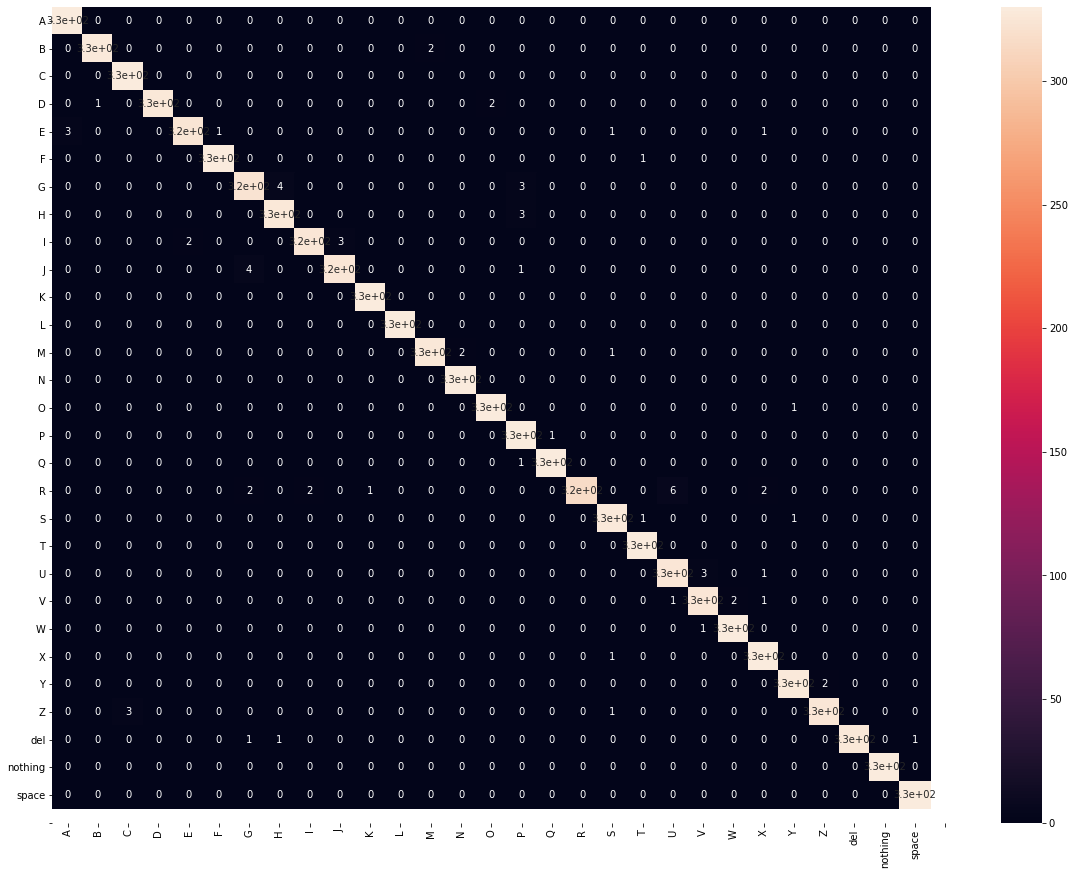

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

(50, 50, 3)


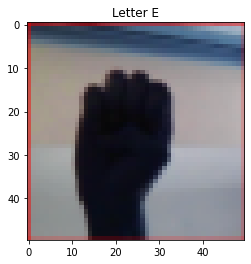

In [ ]:
showLetter('E')

(50, 50, 3)


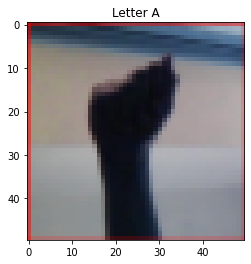

In [ ]:
showLetter('A')

Takođe smatramo da je prihvatljivo da model greši pri klasifikaciji slova *J* u 1% i umesto njega klasifikuje u slovo *G*, jer iz narednih slika možemo videti da bi tako nešto i osoba mogla pogrešiti.

(50, 50, 3)


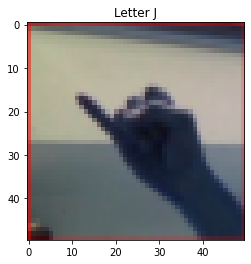

In [ ]:
showLetter('J')

(50, 50, 3)


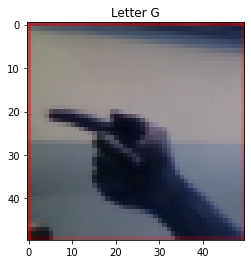

In [ ]:
showLetter('G')

Interesantno je primetiti da model nijednom nije pogrešio pri klasifikaciji slova *K* i *V* iako su vrlo slični u znakovnom jeziku.


(50, 50, 3)


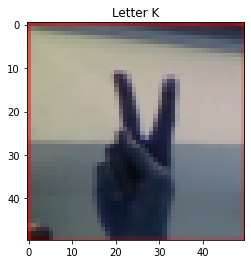

In [ ]:
showLetter('K')

(50, 50, 3)


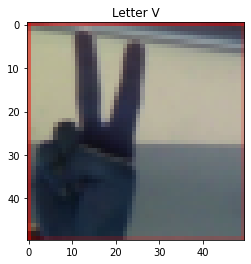

In [ ]:
showLetter('V')

**Model iz naučnog rada**  
Sledeći pokušaj rešavanja datog problema je bio uz pomoć pronađenog naučnog rada koji možete pogledati [ovde](https://www.researchgate.net/publication/337285019_Static_Sign_Language_Recognition_Using_Deep_Learning). U ovom modelu za razliku od prethodnog se slike učitavaju kao *grayscale* slike. Kako grayscale slike zauzimaju manje memorije ovaj model mogao bi uzimati u obzir više slika kako to memorijska ograničenja dozvoljavaju, međutim u cilju uniformnosi i lakšeg poređenja modela korišćen je isti broj elemenata za svako slovo.
Iako se skupovi podataka razlikuju, pokušali smo sa predloženim modelom: korišćena je neuronska mreža sa propagacijom unapred, gde se dodaju sledeći slojevi:  
**1 sloj:** Konvolucioni sloj sa *16* filtera, kernelom veličine *2x2* i *ReLu* aktivacionom funkcijom.    
**2 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti, veličinom bloka *2x2*, veličinom pomeraja *2x2* i uokvirenjem tako da veličina izlazne slike može biti istih dimenzija.  
**3 sloj:** Konvolucioni sloj sa *32* filtera, kernelom veličine *3x3* i *ReLu* aktivacionom funkcijom.    
**4 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti, veličinom bloka *3x3*, veličinom pomeraja *3x3* i uokvirenjem tako da veličina izlazne slike može biti istih dimenzija.   
**5 sloj:** Konvolucioni sloj sa *64* filtera, kernelom veličine *5x5* i *ReLu* aktivacionom funkcijom.  
Zatim funkcija koja se koristi za transformisanje matrica u vektore *Flatten*.    
**6 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *128* i ReLu aktivacionom funkcijom.  
Zatim tehnika regularizacije kojom isključujemo nasumično odabrane neurone i omogućavamo drugačiji protok podataka kroz mrežu *Dropout*.
**7 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *30* i *softmax* aktivacionom funkcijom. 

In [ ]:
# Creating model
paper_model = Sequential()
paper_model.add(Conv2D(16, (2,2), input_shape=(50,50,1), activation='relu'))
paper_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
paper_model.add(Conv2D(32, (3,3), activation='relu'))
paper_model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same'))
paper_model.add(Conv2D(64, (5,5), activation='relu'))
paper_model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))
paper_model.add(Flatten())
paper_model.add(Dense(128, activation='relu'))
paper_model.add(Dropout(0.2))
paper_model.add(Dense(numOfClasses, activation='softmax'))

In [ ]:
# Model summary per layers
paper_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 49, 49, 16)        80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

**Mrežu ćemo trenirati prema sledećim smernicama:**  
*Funkcija greške*: Kategorička unakrsna entropija  
*Optimizator*: Adam sa korakom učenja **0.001**   
*Broj epoha*: **100**  
*Veličina paketića za treniranje* (engl. batch size): **500**  

Za evaluaciju mreže koristimo **preciznost**.


In [ ]:
paper_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Train model
paper_history = paper_model.fit(X_train_gray, y_train_gray,
                    batch_size=500,
                    epochs=100,
                    verbose=1,
                    validation_split=0.2, 
                    shuffle=True)

Epoch 1/100
32/32 [==============================] - 1s 26ms/step - loss: 3.3678 - accuracy: 0.0527 - val_loss: 3.2980 - val_accuracy: 0.1253
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 3.1132 - accuracy: 0.1308 - val_loss: 2.7737 - val_accuracy: 0.2638
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 2.5384 - accuracy: 0.2548 - val_loss: 2.2078 - val_accuracy: 0.3870
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 2.0833 - accuracy: 0.3652 - val_loss: 1.8206 - val_accuracy: 0.4812
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 1.7849 - accuracy: 0.4435 - val_loss: 1.6166 - val_accuracy: 0.5149
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 1.5794 - accuracy: 0.5036 - val_loss: 1.3870 - val_accuracy: 0.6101
Epoch 7/100
32/32 [==============================] - 1s 19ms/step - loss: 1.4039 - accuracy: 0.5574 - val_loss: 1.2952 - val_accuracy: 0.6212
Epoch 

Za razliku od prethodnog modela vidimo da ovom modelu malo sporije opada funkcija gubitka, odnosno raste funkcija preciznosti u prvih 20 epoha. Interesantno je primetiti da iako je u prvoj epohi preciznost na validacionom skupu bila 10%, a u prethodnom modelu 50%, to nije smetalo da model za svih 100 epoha dodje do preciznosti od 96% na validacionom skupu.

**Brzina treniranja modela**

Kako za treniranje u svakoj od epoha u proseku bilo potrebno po 1.20s za treniranje celog skupa bilo je potrebno približno 2 minuta 

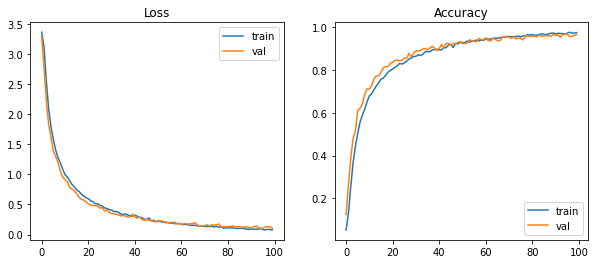

In [ ]:
plot_loss_accuracy(100, paper_history)

In [ ]:
# Evaluate model
paper_score_test = paper_model.evaluate(X_test_gray, y_test_gray, verbose=0)
print('Test loss:', paper_score_test[0])
print('Test accuracy:', paper_score_test[1])

Test loss: 0.11661536246538162
Test accuracy: 0.9617555141448975


In [ ]:
# Evaluate model
paper_score_train = paper_model.evaluate(X_train_gray, y_train_gray, verbose=0)
print('Test loss:', paper_score_train[0])
print('Test accuracy:', paper_score_train[1])

Test loss: 0.04703972488641739
Test accuracy: 0.9885228872299194


Prema klasifikacionom izveštaju vidimo da postoji klasa gde je preciznost bila cak 90% što je značajno manje od minimalne preciznosti po klasi u prethodnom modelu.

In [ ]:
show_classification_report(paper_model, X_test_gray, y_test_gray)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       330
           1       0.97      0.97      0.97       330
           2       0.99      0.99      0.99       330
           3       0.98      0.99      0.98       330
           4       0.92      0.94      0.93       330
           5       0.99      0.99      0.99       330
           6       0.99      0.95      0.97       330
           7       0.96      1.00      0.98       330
           8       0.95      0.96      0.95       330
           9       0.97      0.98      0.98       330
          10       0.92      0.98      0.95       330
          11       0.99      0.99      0.99       330
          12       0.95      0.96      0.95       330
          13       0.98      0.93      0.96       330
          14       0.95      0.98      0.96       330
          15       0.98      1.00      0.99       330
          16       0.99      0.97      0.98       330
          17       0.91    

Analizirajući matricu konfuzije možemo zaključiti da ovaj model dosta puta greši kada klasifikuje slovo *A* i umesto njega klasifikuje u slovo *E*. Obratili smo pažnju na to da je prethodni model uspešno mogao da razlikuje ovaj slučaj, ali se mučio pri klasifikovanju slova *E*. Pri analizi prethodnog modela smo se ubedili da su u znakovnom jeziku ova dva slova slična. Takođe iz matrice konfuzije vidimo da model dosta puta pogreši pri klasifikaciji slova *S*, jer ga meša sa slovom *X*. Nakon matrice konfuzije su prikazana oba slova.  

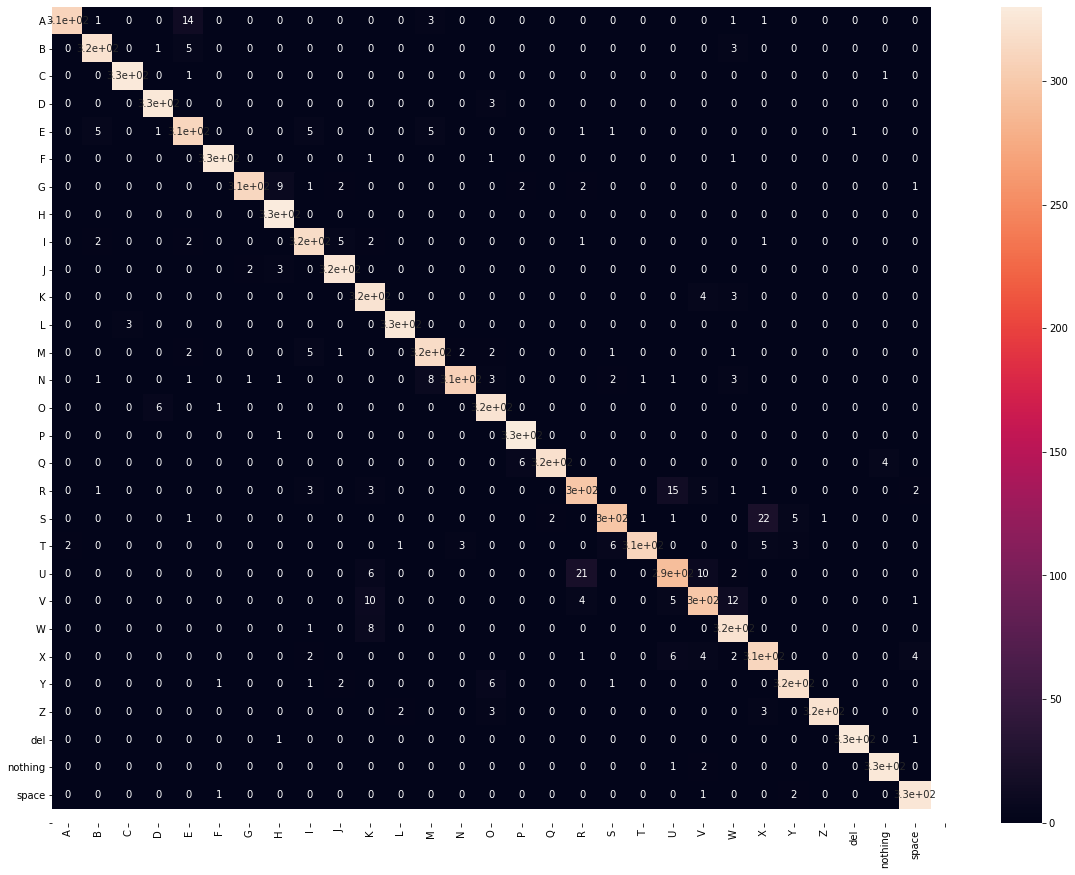

In [ ]:
plot_confusion_matrix(paper_model, X_test_gray, y_test_gray)

(50, 50, 3)


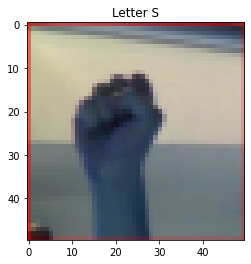

In [ ]:
showLetter('S')

(50, 50, 3)


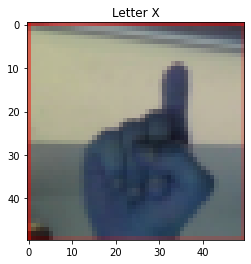

In [ ]:
showLetter('X')

Takođe je interesantno primetiti da uglavnom u svim do sad razmatranim slučajevima prethodni model greši za svaka dva slova u jednom pravcu. Tj, greše pri klasifikaciji slova *A* u *E* ali ne i obrnuto. Trenutno razmatrani model za slova *R* i *U* greši u oba pravca, a možemo videti i zašto.

(50, 50, 3)


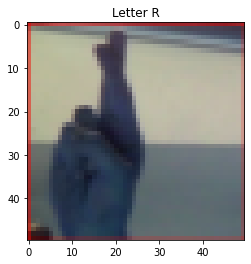

In [ ]:
showLetter('R')

(50, 50, 3)


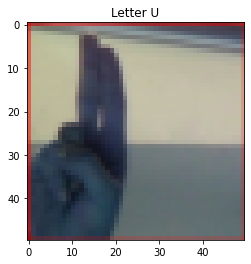

In [ ]:
showLetter('U')

**AlexNet model**  
Sledeći pokušaj rešavanja datog problema je bio uz pomoć arhitekture AlexNet mreže, koju je predstavio naučnik Aleks Križevski. Korišćena je neuronska mreža sa propagacijom unapred, gde se dodaju sledeći slojevi:  
**1 sloj:** Konvolucioni sloj sa *96* filtera, kernelom veličine *11x11*, veličinom pomeraja *4x4*.  
**2 sloj:** Sloj *Batch* normalizacije.  
**3 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti, veličinom bloka *2x2*, veličinom pomeraja *2x2*.  
**4 sloj:** Konvolucioni sloj sa *256* filtera, kernelom veličine *5x5*, veličinom pomeraja *1x1*.  
**5 sloj:** Sloj *Batch* normalizacije.  
**6 sloj:** Kao i treći sloj.  
**7 sloj:** Konvolucioni sloj sa *384* filtera, kernelom veličine *3x3*, veličinom pomeraja *1x1*.  
**8 sloj:** Sloj *Batch* normalizacije.  
**9 sloj:** Kao i sedmi sloj.  
**10 sloj:** Kao i osmi sloj.  
**11 sloj:** Konvolucioni sloj sa *256* filtera, kernelom veličine *3x3*, veličinom pomeraja *1x1*.  
**12 sloj:** Sloj *Batch* normalizacije.  
**13 sloj:** Kao i treći sloj.  
Zatim funkcija koja se koristi za transformisanje matrica u vektore *Flatten*.  
**14 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *4096*.  
**15 sloj:** Sloj *Batch* normalizacije.  
Zatim funkcija koja se koristi da ne bi došlo do preprilagođavanja podataka *Dropout*.   
**16 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *4096*.   
**17 sloj:** Sloj *Batch* normalizacije.  
Zatim funkcija koja se koristi da ne bi došlo do preprilagođavanja podataka *Dropout*.   
**18 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *1000*.   
**19 sloj:** Sloj *Batch* normalizacije. 
Zatim funkcija koja se koristi da ne bi došlo do preprilagođavanja podataka *Dropout*.  
**20 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *30* i *softmax* aktivacionom funkcijom.  
**21 sloj:** Sloj *Batch* normalizacije. 

In [ ]:
# Creating model

alexnet_model = Sequential()
alexnet_model.add(Conv2D(filters=96, input_shape=(50,50,3), kernel_size=(11,11), strides=(4,4), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

alexnet_model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

alexnet_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))

alexnet_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))

alexnet_model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

alexnet_model.add(Flatten())
alexnet_model.add(Dense(4096, input_shape=(50,50,3)))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))
alexnet_model.add(Dense(4096))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))

alexnet_model.add(Dense(1000))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))

alexnet_model.add(Dense(numOfClasses))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('softmax'))

In [ ]:
# Model summary per layers
alexnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 13, 13, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 13, 13, 96)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 256)        

**Mrežu ćemo trenirati prema sledećim smernicama:**  
*Funkcija greške*: Kategorička unakrsna entropija  
*Optimizator*: Adam sa korakom učenja **0.001**   
*Broj epoha*: **100**  
*Veličina paketića za treniranje* (engl. batch size): **128**  

Za evaluaciju mreže koristimo **preciznost**.

In [ ]:
alexnet_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
alexnet_history = alexnet_model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_split=0.2, 
                    shuffle=True)

Epoch 1/100
122/122 [==============================] - 4s 35ms/step - loss: 2.3475 - accuracy: 0.3271 - val_loss: 5.1249 - val_accuracy: 0.0471
Epoch 2/100
122/122 [==============================] - 4s 31ms/step - loss: 1.3162 - accuracy: 0.6458 - val_loss: 4.3825 - val_accuracy: 0.1408
Epoch 3/100
122/122 [==============================] - 4s 31ms/step - loss: 0.8363 - accuracy: 0.7873 - val_loss: 2.4457 - val_accuracy: 0.3873
Epoch 4/100
122/122 [==============================] - 4s 31ms/step - loss: 0.5814 - accuracy: 0.8562 - val_loss: 1.7600 - val_accuracy: 0.5422
Epoch 5/100
122/122 [==============================] - 4s 31ms/step - loss: 0.4256 - accuracy: 0.9021 - val_loss: 1.2023 - val_accuracy: 0.6891
Epoch 6/100
122/122 [==============================] - 4s 31ms/step - loss: 0.3474 - accuracy: 0.9176 - val_loss: 3.1827 - val_accuracy: 0.2450
Epoch 7/100
122/122 [==============================] - 4s 32ms/step - loss: 0.2825 - accuracy: 0.9368 - val_loss: 1.0109 - val_accuracy:

Za razliku od prethodna dva modela na osnovu sledećeg grafika možemo videti da funkcija gubitka i preciznosti za validacioni skup ima značajne skokove, zbog koji će ukupna preciznost modela pasti na 91%, što čini ovaj model najgorim modelom od svih do sad predstavljenih.

**Brzina treniranja modela**

Kako za treniranje u svakoj od epoha u proseku bilo potrebno po 4.30s za treniranje celog skupa bilo je potrebno približno 7.2 minuta 

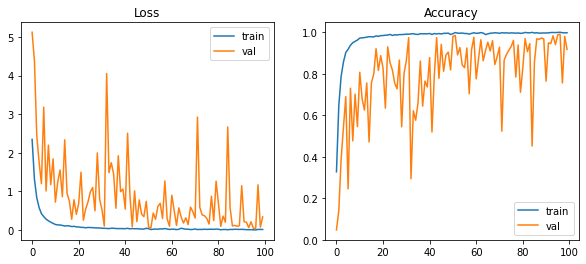

In [ ]:
plot_loss_accuracy(100, alexnet_history)

In [ ]:
# Evaluate model
alexnet_score_test = alexnet_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', alexnet_score_test[0])
print('Test accuracy:', alexnet_score_test[1])

Test loss: 0.3367091715335846
Test accuracy: 0.9184952974319458


In [ ]:
# Evaluate model
alexnet_score_train = alexnet_model.evaluate(X_train, y_train, verbose=0)
print('Test loss:', alexnet_score_train[0])
print('Test accuracy:', alexnet_score_train[1])

Test loss: 0.2916167378425598
Test accuracy: 0.9284096956253052


In [ ]:
show_classification_report(alexnet_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       330
           1       1.00      0.99      0.99       330
           2       0.91      1.00      0.95       330
           3       1.00      0.97      0.98       330
           4       0.99      0.91      0.95       330
           5       0.88      1.00      0.93       330
           6       0.99      1.00      0.99       330
           7       1.00      0.99      1.00       330
           8       1.00      0.97      0.98       330
           9       1.00      0.99      0.99       330
          10       0.79      1.00      0.88       330
          11       0.87      1.00      0.93       330
          12       0.88      0.92      0.89       330
          13       1.00      0.75      0.86       330
          14       0.74      0.98      0.84       330
          15       0.83      1.00      0.91       330
          16       0.97      0.93      0.95       330
          17       0.94    

Zanimljivo je primetiti da je model najviše pogresio klasifikujući slovo *X*, gde je pogrešno klasifikovao u klasu *O*. Gledajući na znakove ova dva slova, nije jasno zašto ih mreža meša.

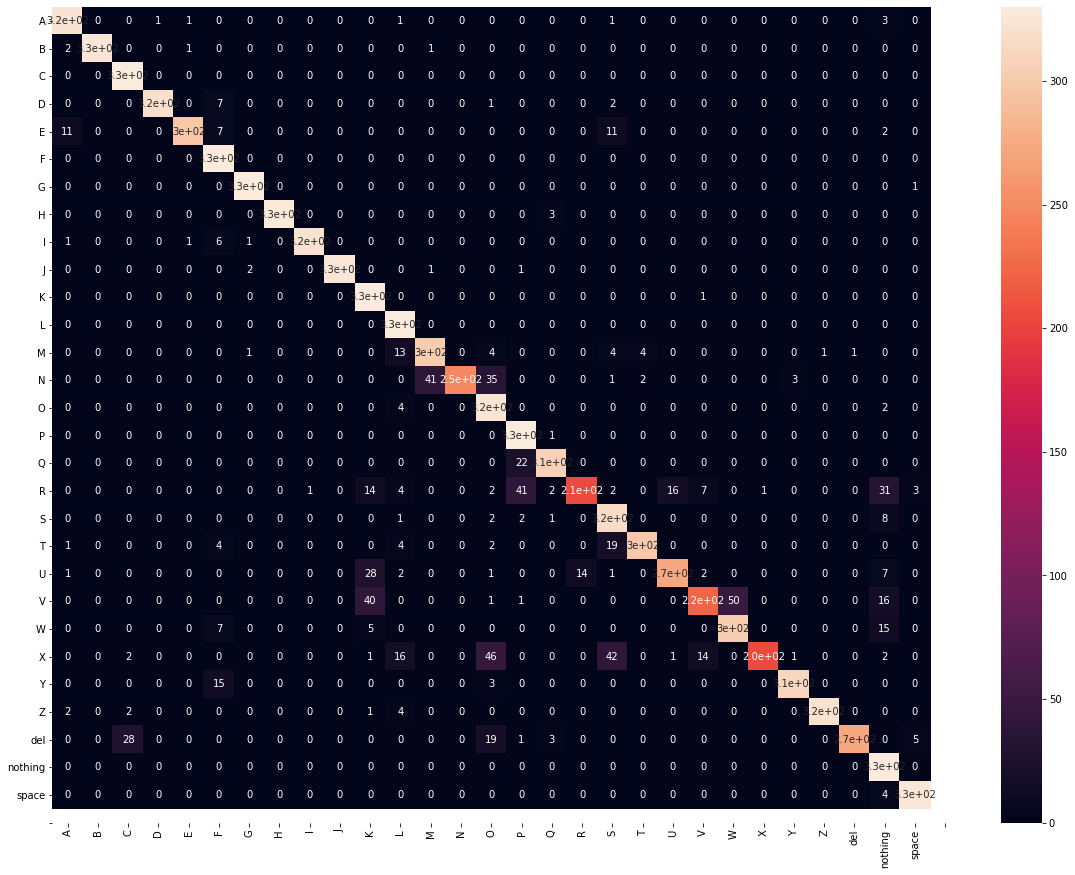

In [ ]:
plot_confusion_matrix(alexnet_model, X_test, y_test)

(50, 50, 3)


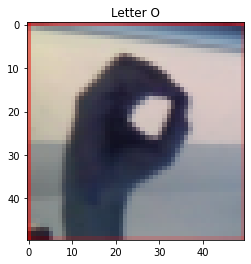

In [ ]:
showLetter('O')

(50, 50, 3)


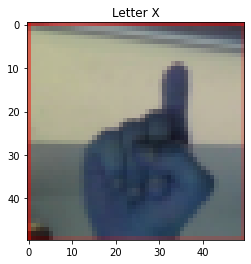

In [ ]:
showLetter('X')

**VGG16 model**  
Sledeći pokušaj rešavanja datog problema je bio uz pomoć arhitekture VGG16 mreže. Korišćena je neuronska mreža sa propagacijom unapred, gde se dodaju sledeći slojevi:  
**1 sloj:** Konvolucioni sloj sa *64* filtera, kernelom veličine *3x3*, okvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.  
**2 sloj:** Kao i prvi sloj.  
**3 sloj:** Agregacioni sloj koji vrši redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne vrednosti, veličinom bloka *2x2*, veličinom pomeraja *2x2*.  
**4 sloj:** Konvolucioni sloj sa *128* filtera, kernelom veličine *3x3*, okvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.  
**5 sloj:** Kao i četvrti sloj.   
**6 sloj:** Kao i treći sloj.     
**7 sloj:** Konvolucioni sloj sa *256* filtera, kernelom veličine *3x3*, okvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.  
**8 sloj:** Kao i sedmi sloj.  
**9 sloj:** Kao i sedmi sloj.  
**10 sloj:** Konvolucioni sloj sa *512* filtera, kernelom veličine *3x3*, okvirenjem tako da veličina izlazne slike može biti istih dimenzija i *ReLu* aktivacionom funkcijom.  
**11 sloj:** Kao i deseti sloj.  
**12 sloj:** Kao i deseti sloj.  
**13 sloj:** Kao i treći sloj.  
**14 sloj:** Kao i deseti sloj.  
**15 sloj:** Kao i deseti sloj.  
**16 sloj:** Kao i deseti sloj.  
**17 sloj:** Kao i treći sloj.  
Zatim funkcija koja se koristi za transformisanje matrica u vektore *Flatten*.  
**18 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *4096* i *ReLu* aktivacionom funkcijom.   
**19 sloj:** Kao i 18. sloj.  
**20 sloj:** Potpuno povezan sloj sa brojem izlaznih neurona *30* i *softmax* aktivacionom funkcijom. 


In [ ]:
# VGG16 model
vgg16_model = Sequential()
vgg16_model.add(Conv2D(input_shape=(50,50,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))

vgg16_model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

vgg16_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

vgg16_model.add(Flatten())
vgg16_model.add(Dense(units=4096, activation="relu"))
vgg16_model.add(Dense(units=4096, activation="relu"))
vgg16_model.add(Dense(units=numOfClasses, activation="softmax"))

In [ ]:
# Model summary per layers
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 50, 50, 64)        1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 256)       295168    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 256)      

In [ ]:
vgg16_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

**Mrežu ćemo trenirati prema sledećim smernicama:**  
*Funkcija greške*: Kategorička unakrsna entropija  
*Optimizator*: Adam sa korakom učenja **0.001**   
*Broj epoha*: **30**  
*Veličina paketića za treniranje* (engl. batch size): **128**  

Za evaluaciju mreže koristimo **preciznost**. 

In [ ]:
# Train model
vgg16_history = vgg16_model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=30,
                    verbose=1,
                    validation_split=0.2, 
                    shuffle=True)

Epoch 1/30
122/122 [==============================] - 28s 232ms/step - loss: 3.3795 - accuracy: 0.0347 - val_loss: 3.3713 - val_accuracy: 0.0353
Epoch 2/30
122/122 [==============================] - 26s 213ms/step - loss: 3.3736 - accuracy: 0.0322 - val_loss: 3.3742 - val_accuracy: 0.0319
Epoch 3/30
122/122 [==============================] - 26s 212ms/step - loss: 3.3711 - accuracy: 0.0309 - val_loss: 3.3715 - val_accuracy: 0.0329
Epoch 4/30
122/122 [==============================] - 26s 212ms/step - loss: 3.3706 - accuracy: 0.0342 - val_loss: 3.3694 - val_accuracy: 0.0327
Epoch 5/30
122/122 [==============================] - 26s 212ms/step - loss: 3.3702 - accuracy: 0.0345 - val_loss: 3.3710 - val_accuracy: 0.0293
Epoch 6/30
122/122 [==============================] - 26s 212ms/step - loss: 3.3700 - accuracy: 0.0334 - val_loss: 3.3704 - val_accuracy: 0.0317
Epoch 7/30
122/122 [==============================] - 26s 211ms/step - loss: 3.3695 - accuracy: 0.0322 - val_loss: 3.3713 - val_ac

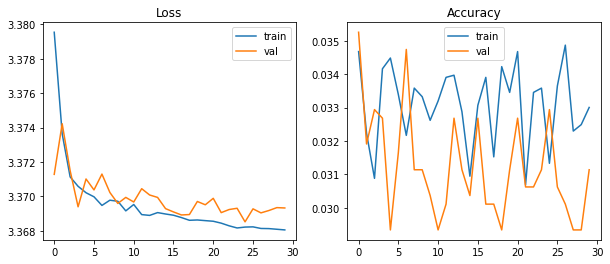

In [ ]:
plot_loss_accuracy(30, vgg16_history)

In [ ]:
# Evaluate model
vgg16_score_test = vgg16_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', vgg16_score_test[0])
print('Test accuracy:', vgg16_score_test[1])

Test loss: 3.367692232131958
Test accuracy: 0.03448275849223137


In [ ]:
# Evaluate model
vgg16_score_train = vgg16_model.evaluate(X_train, y_train, verbose=0)
print('Test loss:', vgg16_score_train[0])
print('Test accuracy:', vgg16_score_train[1])

Test loss: 3.367692232131958
Test accuracy: 0.03448275849223137


Vgg16 model se na zadatom skupu pokazao jako loše pa se postavlja pitanje da li je moguće koristiti ovakav model na ovom skupu podataka. Ostaje videti da li bi se podešavanjem parametara vgg16 mreže nešto promenilo. Nakon promene dimenzije slika na 224x224px i izvršavanja takvog skupa, preciznost nije porasla. 


**Zaključak:**  
Glavni zamisao ovog rada je bio napraviti dovoljno dobar model koji će uspešno klasifikovati znakovni jezik sa nadom da će poslužiti kao značajna osnova za neko buduće istraživanje na ovu temu. Ubedili smo se da je sasvim dovoljno bilo učitati po *1000* slika za svako slovo, jer je i uz pomoć skupa od *30000* slika dobijeni model bio više nego precizan. Kako su podaci korišćeni prilikom samog treniranja obuhvatali slike iz različitih uglova i pod različitim osvetljenjima, verujemo da je dobijeni model reprezentativan za dalju analizu i upotrebu u ovoj oblasti.

Pokazano je da je prvi predstavljen model malo bolji od modela predstavljenog u naučnom radu, dok model pravljen po AlexNet arhitekturi ima manju preciznost od oba.

Najbolji dobijeni model je prvi predstavljeni model i ima preciznost od čak 99%.


Za kraj predstavićemo kako model radi nad test podacima koji se nisu nalazili ni u test ni u trening skupu.

In [ ]:
def checkModel(model, letter):
  testImage = cv2.imread("./data/input/asl-alphabet/asl_alphabet_test/" + letter + "_test.jpg")
  resizedTestImage = proccessImage(testImage, size=(50,50), color=True)

  plt.imshow(resizedTestImage, cmap='gray')
  plt.title("Checking lettter: " + letter)
  plt.show()

  y_predicted = model.predict(np.array([resizedTestImage]))
  y_predicted_class = np.argmax(y_predicted, axis = 1)

  class_names = list(string.ascii_uppercase) + ['del', 'nothing', 'space', '']
  print("Predicted class: " + class_names[int(y_predicted_class)])

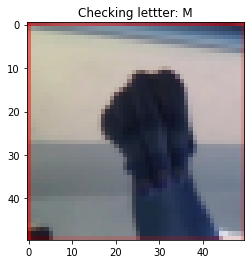

Predicted class: M


In [ ]:
checkModel(model, letter='M')

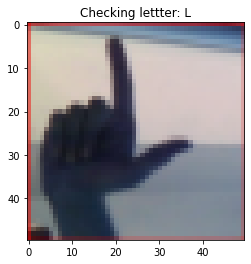

Predicted class: L


In [ ]:
checkModel(model, letter='L')

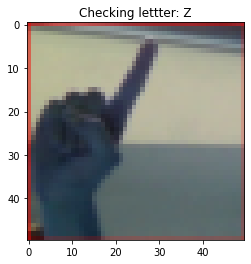

Predicted class: Z


In [ ]:
checkModel(model, letter='Z')